# VIX Premium
Ing-Haw, Cheng, (2018), The Vix Premium

The author defines the vix premium as "the expected dollar loss for a long VIX futures contract with 1$ notional value held through expiration".

$$VIXP_{t}^T = E_{t}^Q[VIX_{T}]-E_{t}^P[VIX_{T}]$$

The VIX is the risk neutral expectation of realized variance over the next 30 days extracted from option prices such that:

$$VIX_{t} = \sqrt{E_{t}^Q[RV_{t,t+30}] }$$

So a VIX future expiring at time T is the risk neutral expectation at time t for VIX. That is why VIX futures are derivatives on a derivative.
The VIXP scaled for one month is given by:

$$\frac{21}{T(t)-t}[E_{t}^Q[VIX_{T(t)}]-E_{t}^P[VIX_{T(t)}]$$

Assuming no arbitrage the risk neutral expectation for VIX is given by the current futures contract:
$$F_{t}^{T(t)}=E_{t}^Q[VIX_{T}] $$
The conditional expectation for VIX  is estimated according to a baseline ARMA(2,2) model such that the VIXP is:
$$\frac{21}{T(t)-t}[F_{t}^{T(t)}-\widehat{VIX_{T(t)}}]$$
The author claims that VIXP falls or stays flat when conditional measures of risk increase. He attributes this to reduced hedging demand in periods of high risk. Furthermore the VIXP is a good predictor of VIX returns and falling VIXP predicts subsequent increases in market risk. He claims that this behavior creates profitable trading opportunities.

Evernote:https://www.evernote.com/shard/s20/nl/2254793/28c806fb-4650-43c9-86fc-282994a59a87/

In [1]:
from pathlib import Path   
import pandas as pd
import numpy as np
import pyfolio as pf
import pandas_datareader as web
from statsmodels.tsa.arima_model import ARMA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as bbox
from matplotlib import rcParams
import seaborn as sns

import quandl
import nest_asyncio

import sys
import socket
opt_path = '/Users/ebellord/PycharmProjects/opt_trade'
if  opt_path not in sys.path:
    sys.path.append(opt_path)

if socket.gethostname() == 'edmunds-mbp.lan':
    %config InlineBackend.figure_format = 'retina'

from option_utilities import perf_stats, chart_format, PlotConstants
from option_simulation import OptionSimulation, plot_performance_quad, OptionTrades
from spx_data_update import UpdateSP500Data, ImpliedVolatilityHistory, \
    VixTSM, SP500Index, CBOEIndex
from implied_to_realized import SPX5MinuteBars
# from overlay_presentation import get_fund_assets

def table1_stats(df, name, mult=1):
    out_series = df.describe().copy()
    out_series[1:] = out_series[1:] * mult
    out_series['First'], out_series['Last'] = [df.index[item].strftime('%b-%y') for item in [0, -1]]
    out_series = out_series.reindex(['count', 'First', 'Last', 'mean', 'std', 'min',
                                    'max', '50%'])
    return out_series.rename(name)

# Data

In [2]:
nest_asyncio.apply()
pc = PlotConstants()

iv_hist = ImpliedVolatilityHistory()
vix = iv_hist.implied_vol_index

vixp_d, vixp_m = [pd.read_excel(UpdateSP500Data.DATA_BASE_PATH / 'xl' / 'VIX_Premium.xlsx', 
                           sheet_name=sheet_name) for sheet_name in ['Daily', 'Monthly']]
vixp_d['dt'], vixp_m['dt'] = [df['dt'].apply(pd.to_datetime) for df in [vixp_d, vixp_m]]
vixp_d, vixp_m = [df.set_index('dt') for df in [vixp_d, vixp_m]]
vixp_d.index.name, vixp_m.index.name = [None for df in [vixp_d, vixp_m]] 

sp5 = SP500Index(update=False)
cboe = CBOEIndex()
bars = SPX5MinuteBars(update_bars=False)

# VIX - VIXP - VIXR Descriptive Statistics

In [20]:
expiry_type = 'eom'
vx = VixTSM(expiry_type)


/Users/ebellord/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


,count,First,Last,mean,std,min,max,50%
CBOE Volatility Index (VIX),141,Mar-04,Nov-15,19.573,8.757,10.42,59.890,16.740
VIX Futures,120,Apr-04,Mar-14,20.576,8.659,11.31,54.570,18.135
VIX Futures return,119,May-04,Mar-14,-3.791,16.931,-30.00,93.373,-6.810
VIXP,140,Mar-04,Oct-15,70.621,141.511,-461.54,419.682,44.447
VIXR,140,Mar-04,Oct-15,-2.511,5.670,-14.03,10.014,-2.393
Realized Volatility,140,Apr-04,Nov-15,15.620,10.388,6.04,80.857,11.826
CBOE SKEW Index,141,Mar-04,Nov-15,120.182,5.842,106.43,139.350,120.130
CBOE VVIX Index,107,Jan-07,Nov-15,86.781,12.528,64.49,127.280,86.080
S&P 500 Excess,140,Apr-04,Nov-15,0.698,4.108,-16.80,10.929,1.291


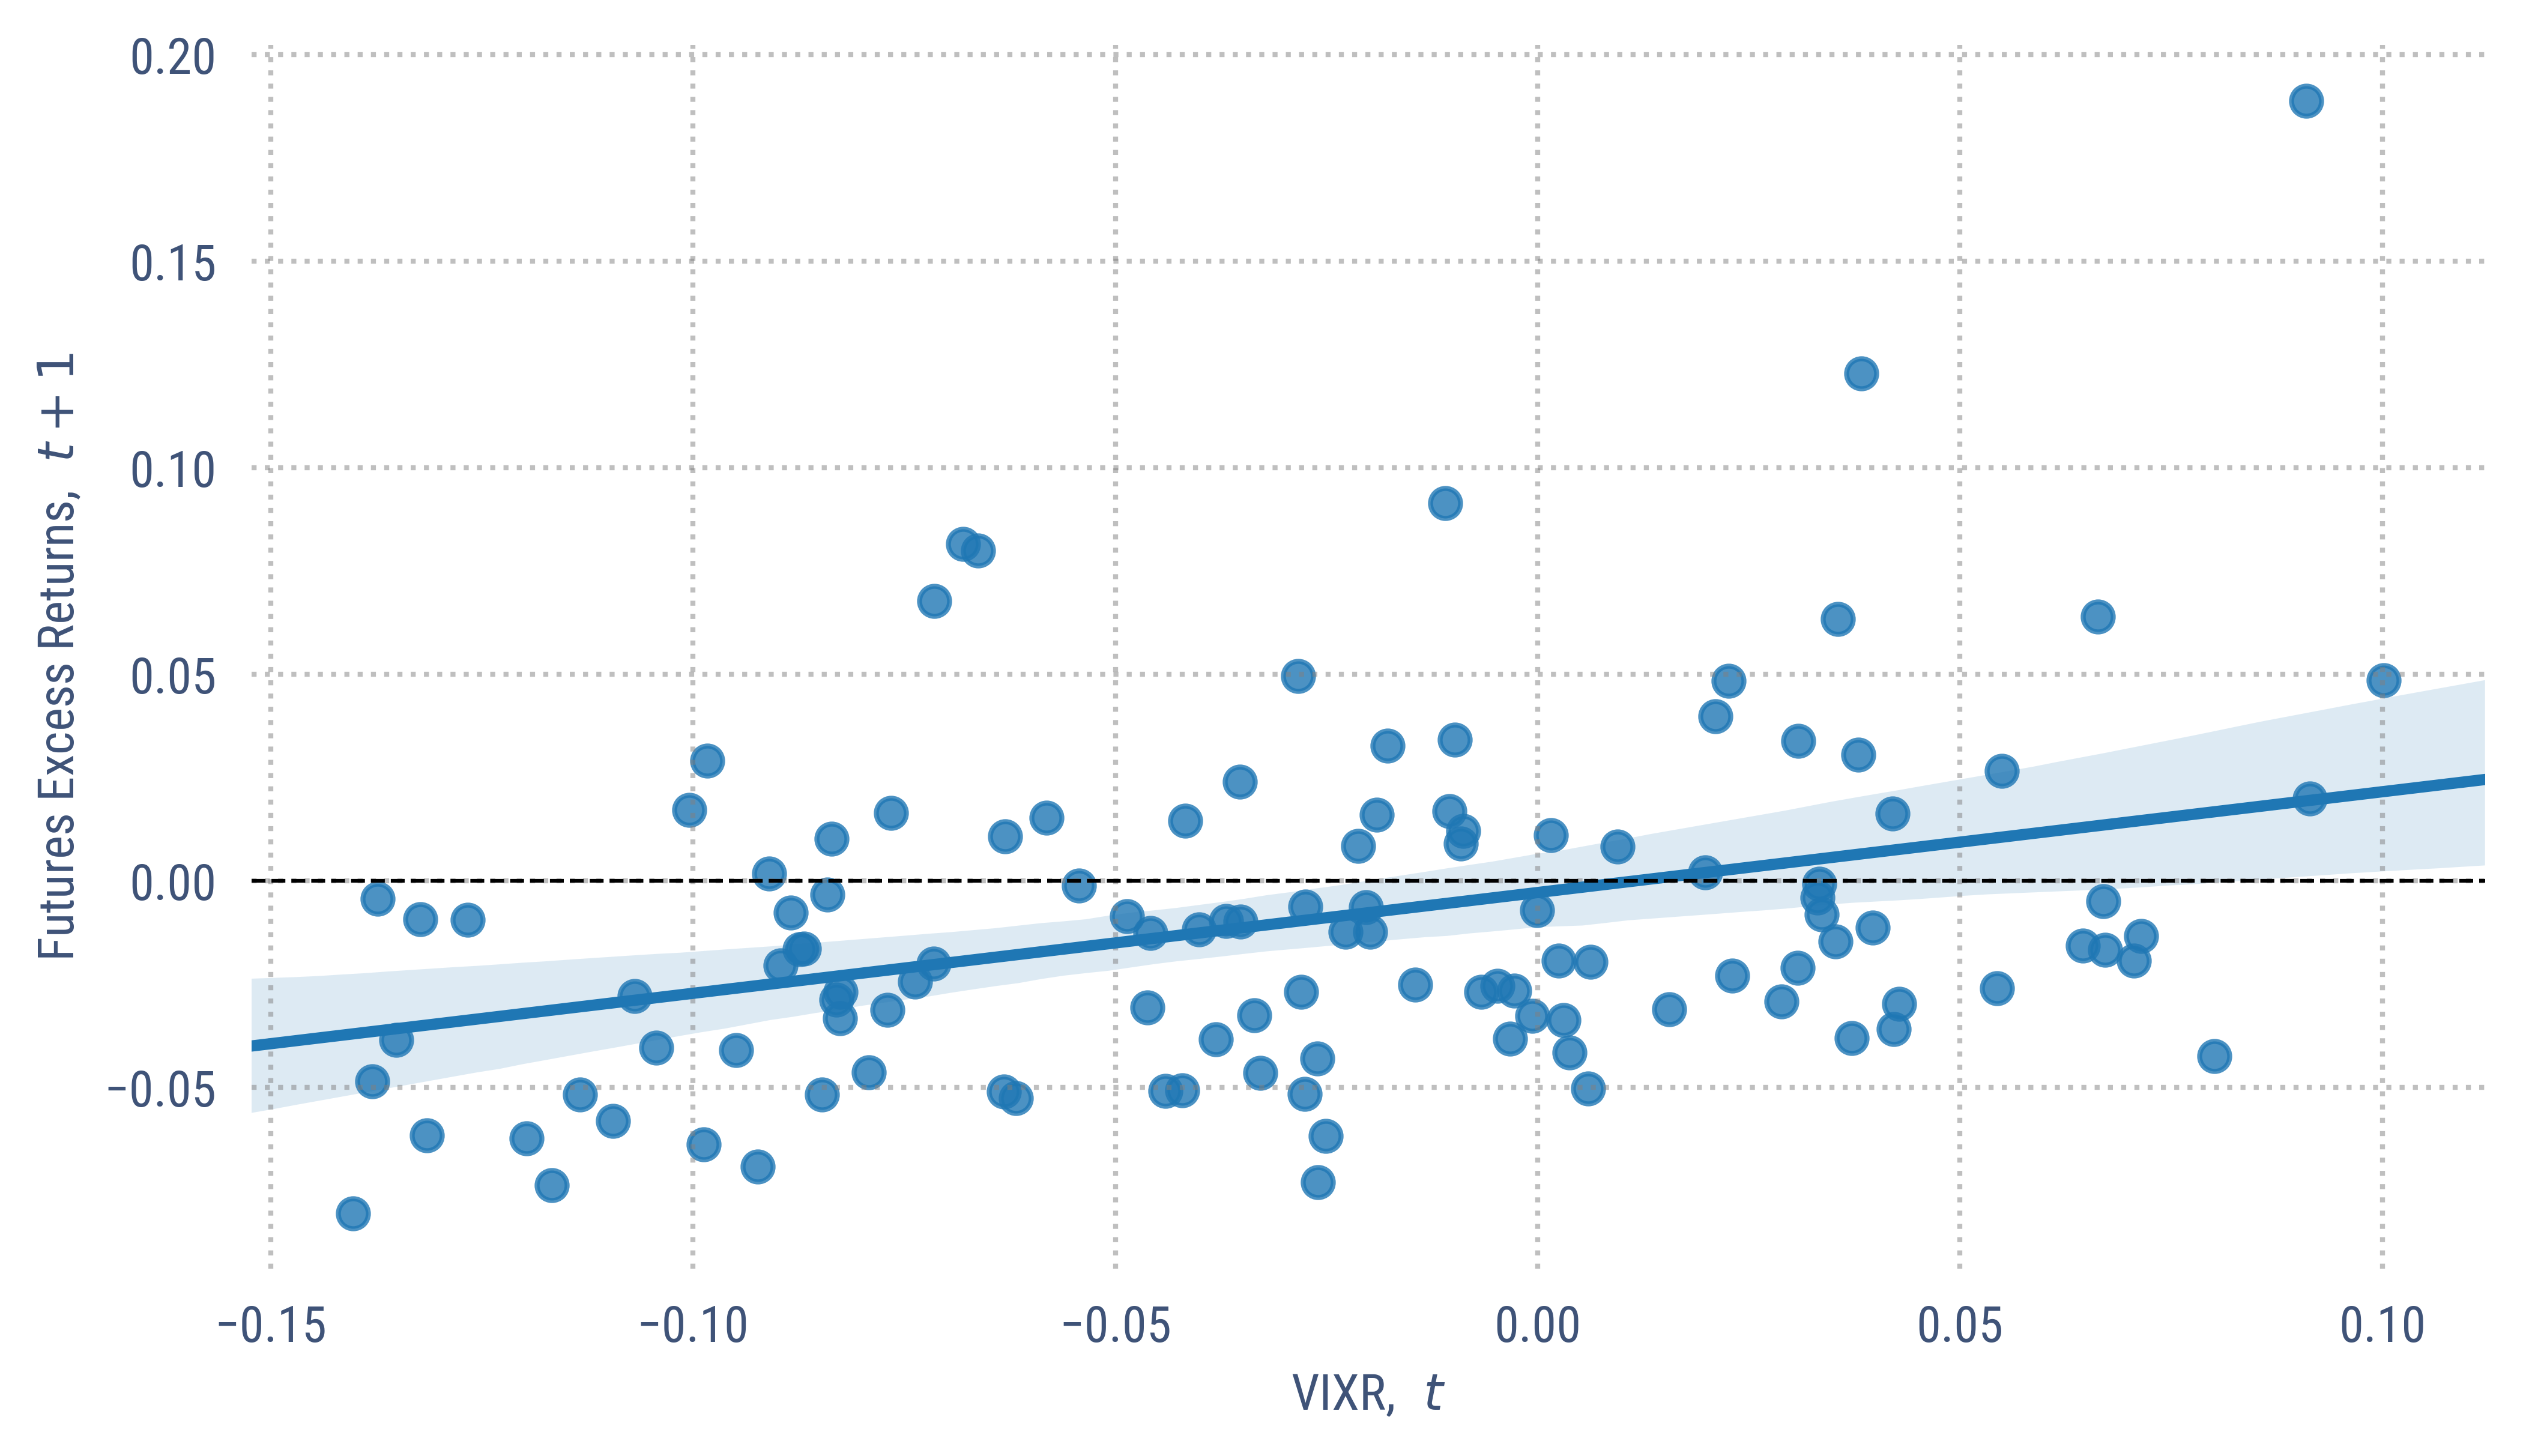

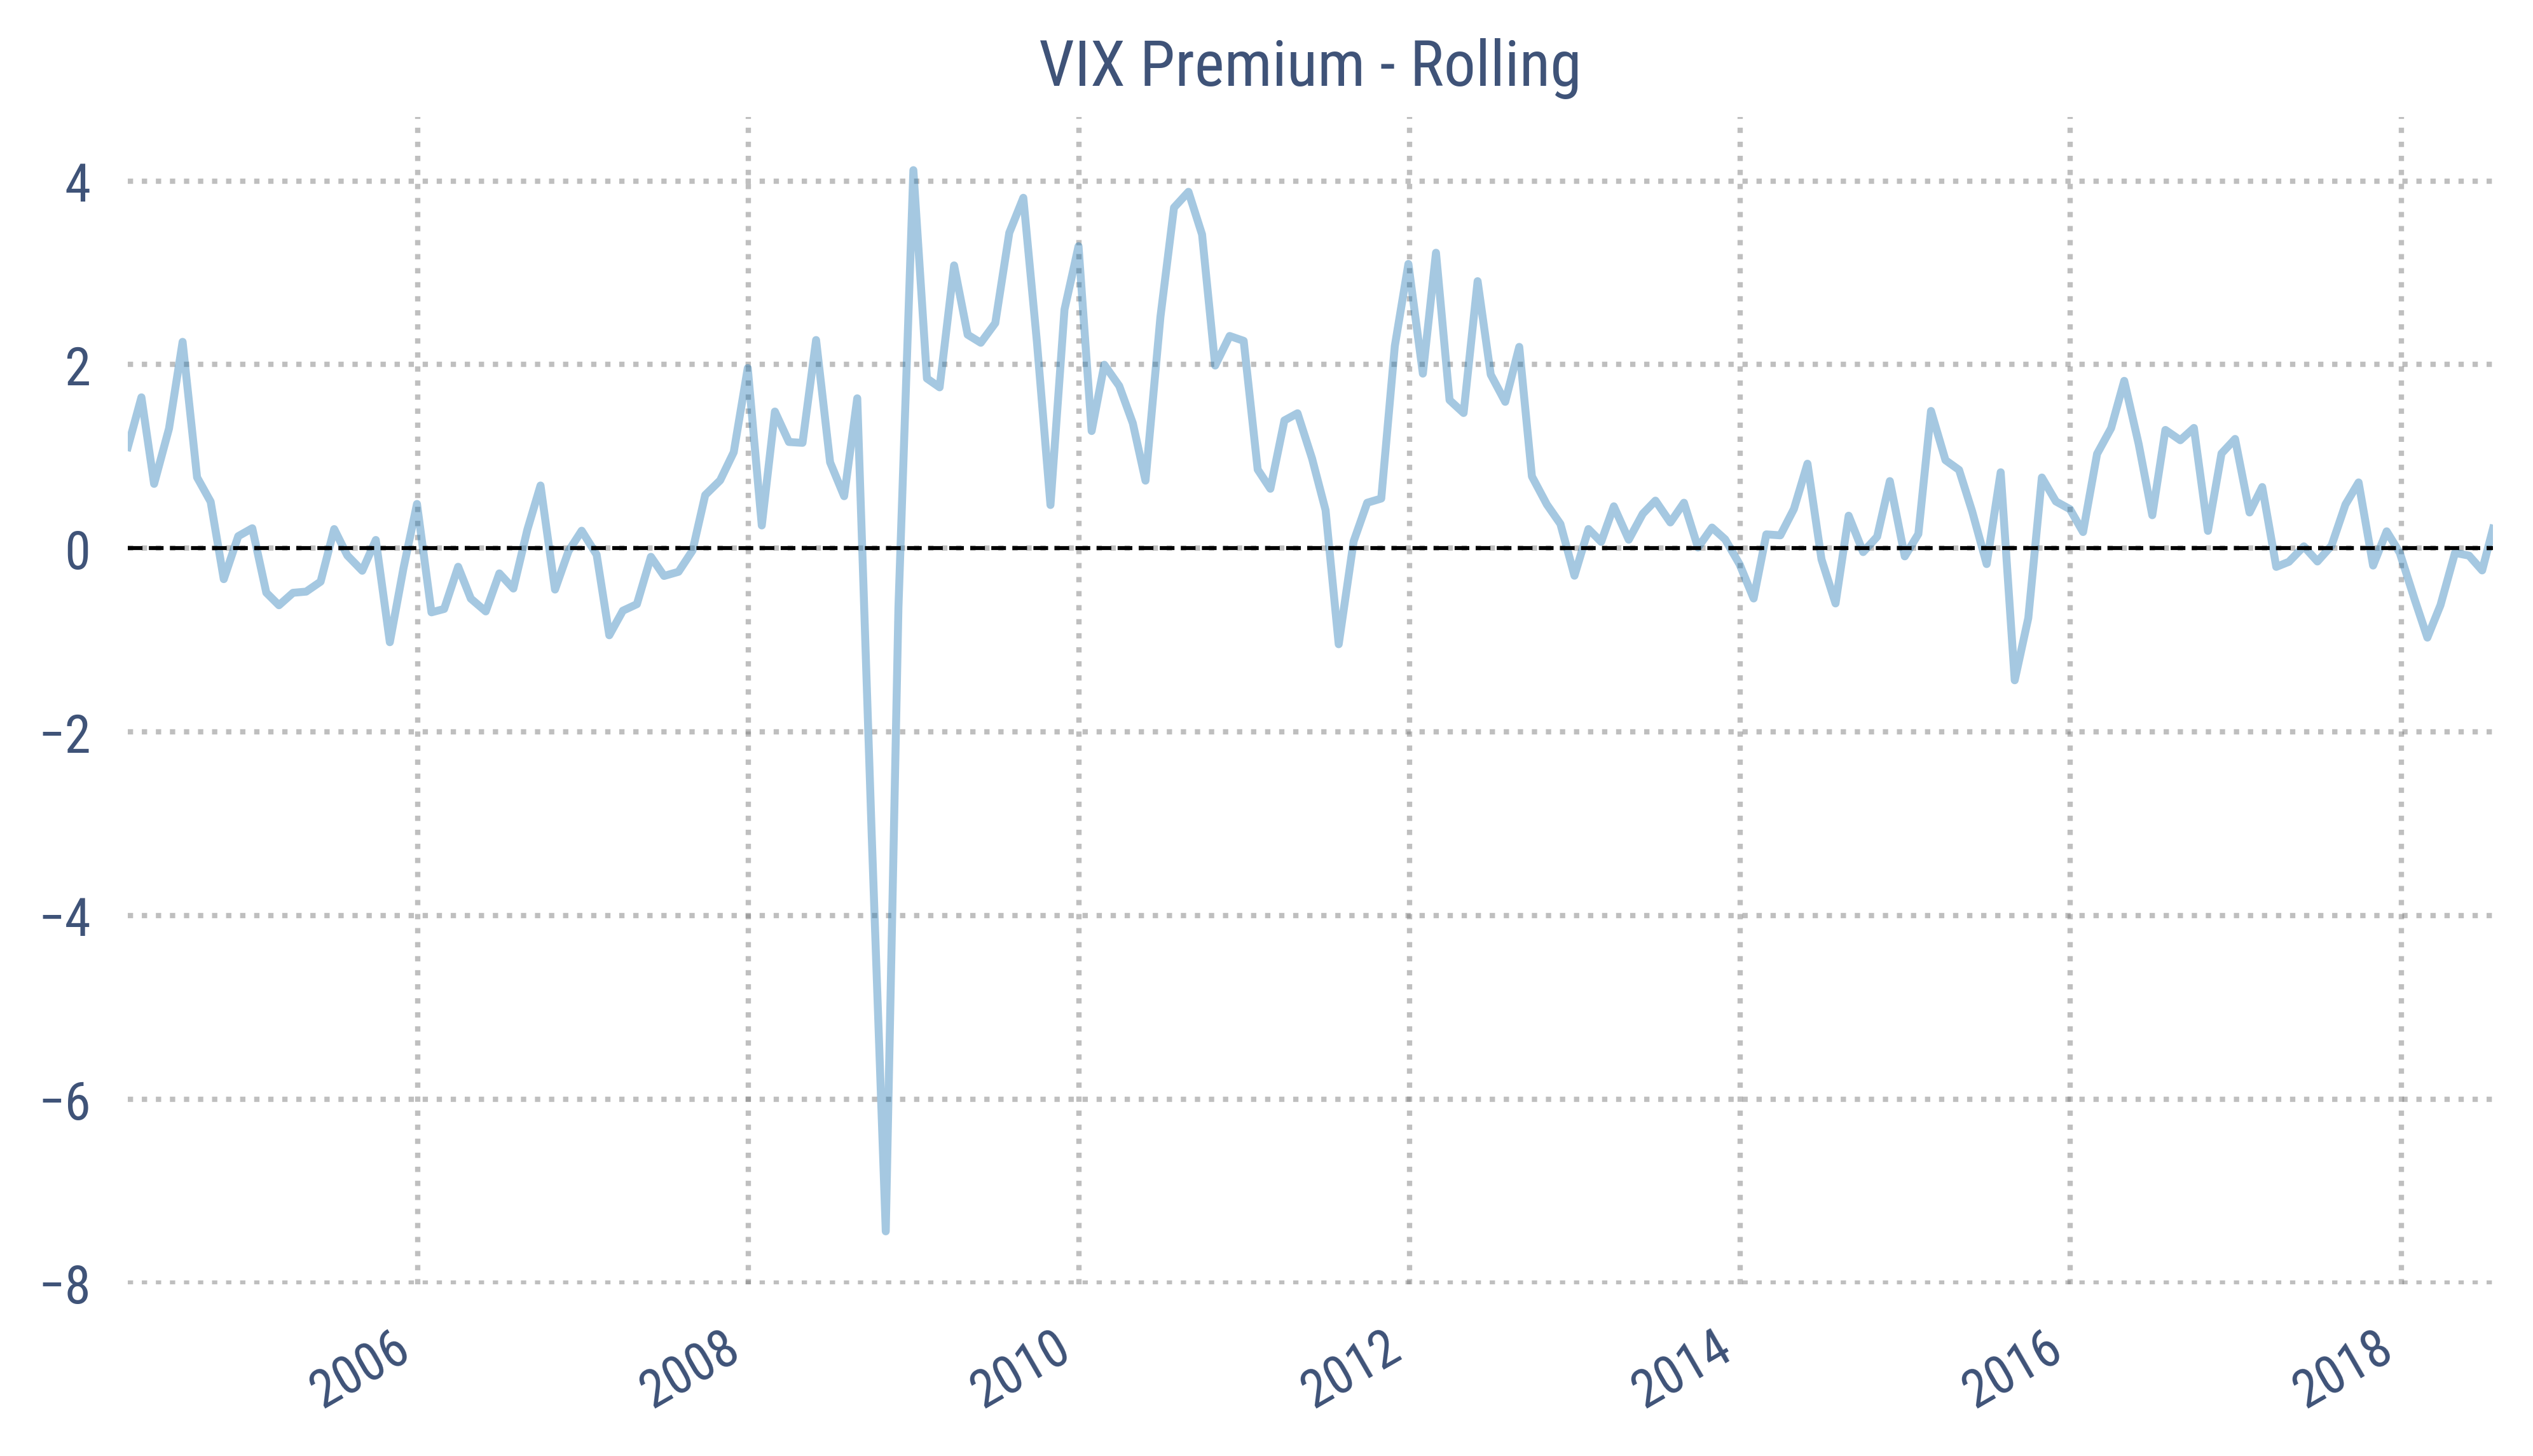

In [21]:
delever_constant = 4
vix_ret_monthly_col = vx.rolled_idx.resample('BM', closed='left').ffill().pct_change().dropna(how='any')
vix_fut_long_ret = vx.rolled_return.dropna(how='any') / delever_constant
vix_fut_short_ret = vx.rolled_return_short.dropna(how='any') / delever_constant

    
vixp_mm = vixp_m['vixr_2004'].resample('BM', closed='left').ffill()
vix_fut_long_idx = pf.timeseries.cum_returns(vix_fut_long_ret, 100)
vix_fut_long_idx_m = vix_fut_long_idx.resample('BM', closed='left').ffill()
vix_fut_long_ret_m = vix_fut_long_idx_m.pct_change().dropna(how='any')
vix_fut_long_ret_m = vix_fut_long_ret_m.rename('Long VIX futures')
vixp_mm_lag = vixp_mm.shift(1).dropna(how='any')

plot_data = pd.concat([vix_fut_long_ret_m, vixp_mm_lag], axis=1).dropna(how='any')
x = vixp_mm_lag.name
y = vix_fut_long_ret_m.name
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')

gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_scat = plt.subplot(gs[:])
ax_plot = sns.regplot(x, y, data=plot_data)
ax_scat.axhline(0,
             color='k',
             ls='--',
             lw=0.75,
             alpha=1.0)
ax_scat.set_ylabel('Futures Excess Returns, $\ {t+1}$')
ax_scat.set_xlabel('VIXR, $\ t$')
chart_format([ax_scat],pc.color_light)

plt.autoscale(enable=True,
              axis='x',
              tight=True)


realized_vol = np.sqrt(bars.realized_variance * 12)
table1 = pd.concat([table1_stats(vix['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'CBOE Volatility Index (VIX)'),
                    table1_stats(vx.rolled_future['02-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'VIX Futures'),
                    table1_stats(vix_ret_monthly_col, 'VIX Futures return', 100),
                    table1_stats(vixp_m['vixp_2004'].dropna(how='any'), 'VIXP', 100),
                    table1_stats(vixp_m['vixr_2004'].dropna(how='any'), 'VIXR', 100),
                    table1_stats(realized_vol['02-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                                 'Realized Volatility', 100),
                    table1_stats(cboe.skew['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                               'CBOE SKEW Index'),
                    table1_stats(cboe.vvix['03-2004':'11-2015'].resample('BM', closed='left').ffill().dropna(how='any'),
                               'CBOE VVIX Index'),
                    table1_stats(sp5.return_index['03-2004':'11-2015'].resample('BM', closed='left').ffill().pct_change().dropna(how='any'),
                                'S&P 500 Excess', 100)], axis=1)


display(table1.transpose().style.set_caption('Table1. Monthly Summary Statistics').format({'mean': '{:,.3f}', 'std': '{:,.3f}', 'min': '{:,.2f}',
                                    'max': '{:,.3f}', '50%': '{:,.3f}'}))
fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(1, 1, wspace=0.5, hspace=0.25)
ax_vixp = plt.subplot(gs[:])
ax_vixp = vixp_m['vixp_rolling'].plot(lw=1.5,
                                    ax=ax_vixp, 
                                    grid=True,
                                    alpha=0.4,
                                    title ='VIX Premium - Rolling')
ax_vixp.axhline(0,
             color='k',
             ls='--',
             lw=0.75,
             alpha=1.0)
chart_format([ax_vixp], pc.color_light)

plt.autoscale(enable=True,
              axis='x',
              tight=True)

# ARMA 2, 2 Model - Expanding Window

In [60]:
train, test = vix[:vx.rolled_idx.index[0]][:-1], vix[vx.rolled_idx.index[:100]]
steps_days = vx.days_2_exp.dt.days
futures = vx.rolled_future

history = [x for x in train]
predictions = list()
yhat_ts = []
vixp_ts = []
vixer_ts = []
for t in range(len(test)):
    model = ARMA(history, order=(2, 2))
    model_fit = model.fit(disp=0, method='css')
    output = model_fit.forecast(steps=steps_days[t] - 1)
    yhat = output[0]
    obs = test[t]
    history.append(obs)
    yhat_ts.append(yhat[-1])
    vixp = (futures[t] - yhat[-1]) * (1 / steps_days[t])
    vixer = (yhat[-1] / futures[t]) ** (1 / steps_days[t]) - 1
    vixp_ts.append(vixp)
    vixer_ts.append(vixer)
    
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3695
Model:                     ARMA(2, 2)   Log Likelihood               -6020.774
Method:                           css   S.D. of innovations              1.235
Date:                Thu, 28 Feb 2019   AIC                          12053.548
Time:                        11:28:29   BIC                          12090.834
Sample:                             2   HQIC                         12066.819
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8333      1.638     12.111      0.000      16.624      23.043
ar.L1.y        1.6822      0.061     27.389      0.000       1.562       1.803
ar.L2.y       -0.6846      0.061    -11.277      0.000      -0.804      -0.566
ma.L1.y       -0.7460      0.063    -11.827      0.000      -0.870      -0.622
ma.L2.y       -0.0575      0.021     -2.714      0.007      -0.099      -0.016
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0079           +0.0000j            1.0079            0.0000
AR.2            1.4492           +0.0000j            1.4492            0.0000
MA.1            1.2248           +0.0000j            1.2248            0.0000
MA.2          -14.2029           +0.0000j           14.2029            0.5000
-----------------------------------------------------------------------------
"""

,count,First,Last,mean,std,min,max,50%
VIXP,100,Apr-04,Aug-04,6.580,3.178,1.04,14.723,6.203
VIXP_calc,100,Apr-04,Aug-04,3.905,3.002,-4.90,12.883,3.641
VIXR,100,Apr-04,Aug-04,-0.374,0.183,-0.87,-0.055,-0.359
VIXR_calc,100,Apr-04,Aug-04,-0.221,0.171,-0.74,0.272,-0.197


,vixp_rolling,vixp_calc_rolling
vixp_rolling,1.000000,0.745829
vixp_calc_rolling,0.745829,1.000000


,vixr_rolling,vixp_calc_rolling
vixr_rolling,1.000000,0.726656
vixp_calc_rolling,0.726656,1.000000


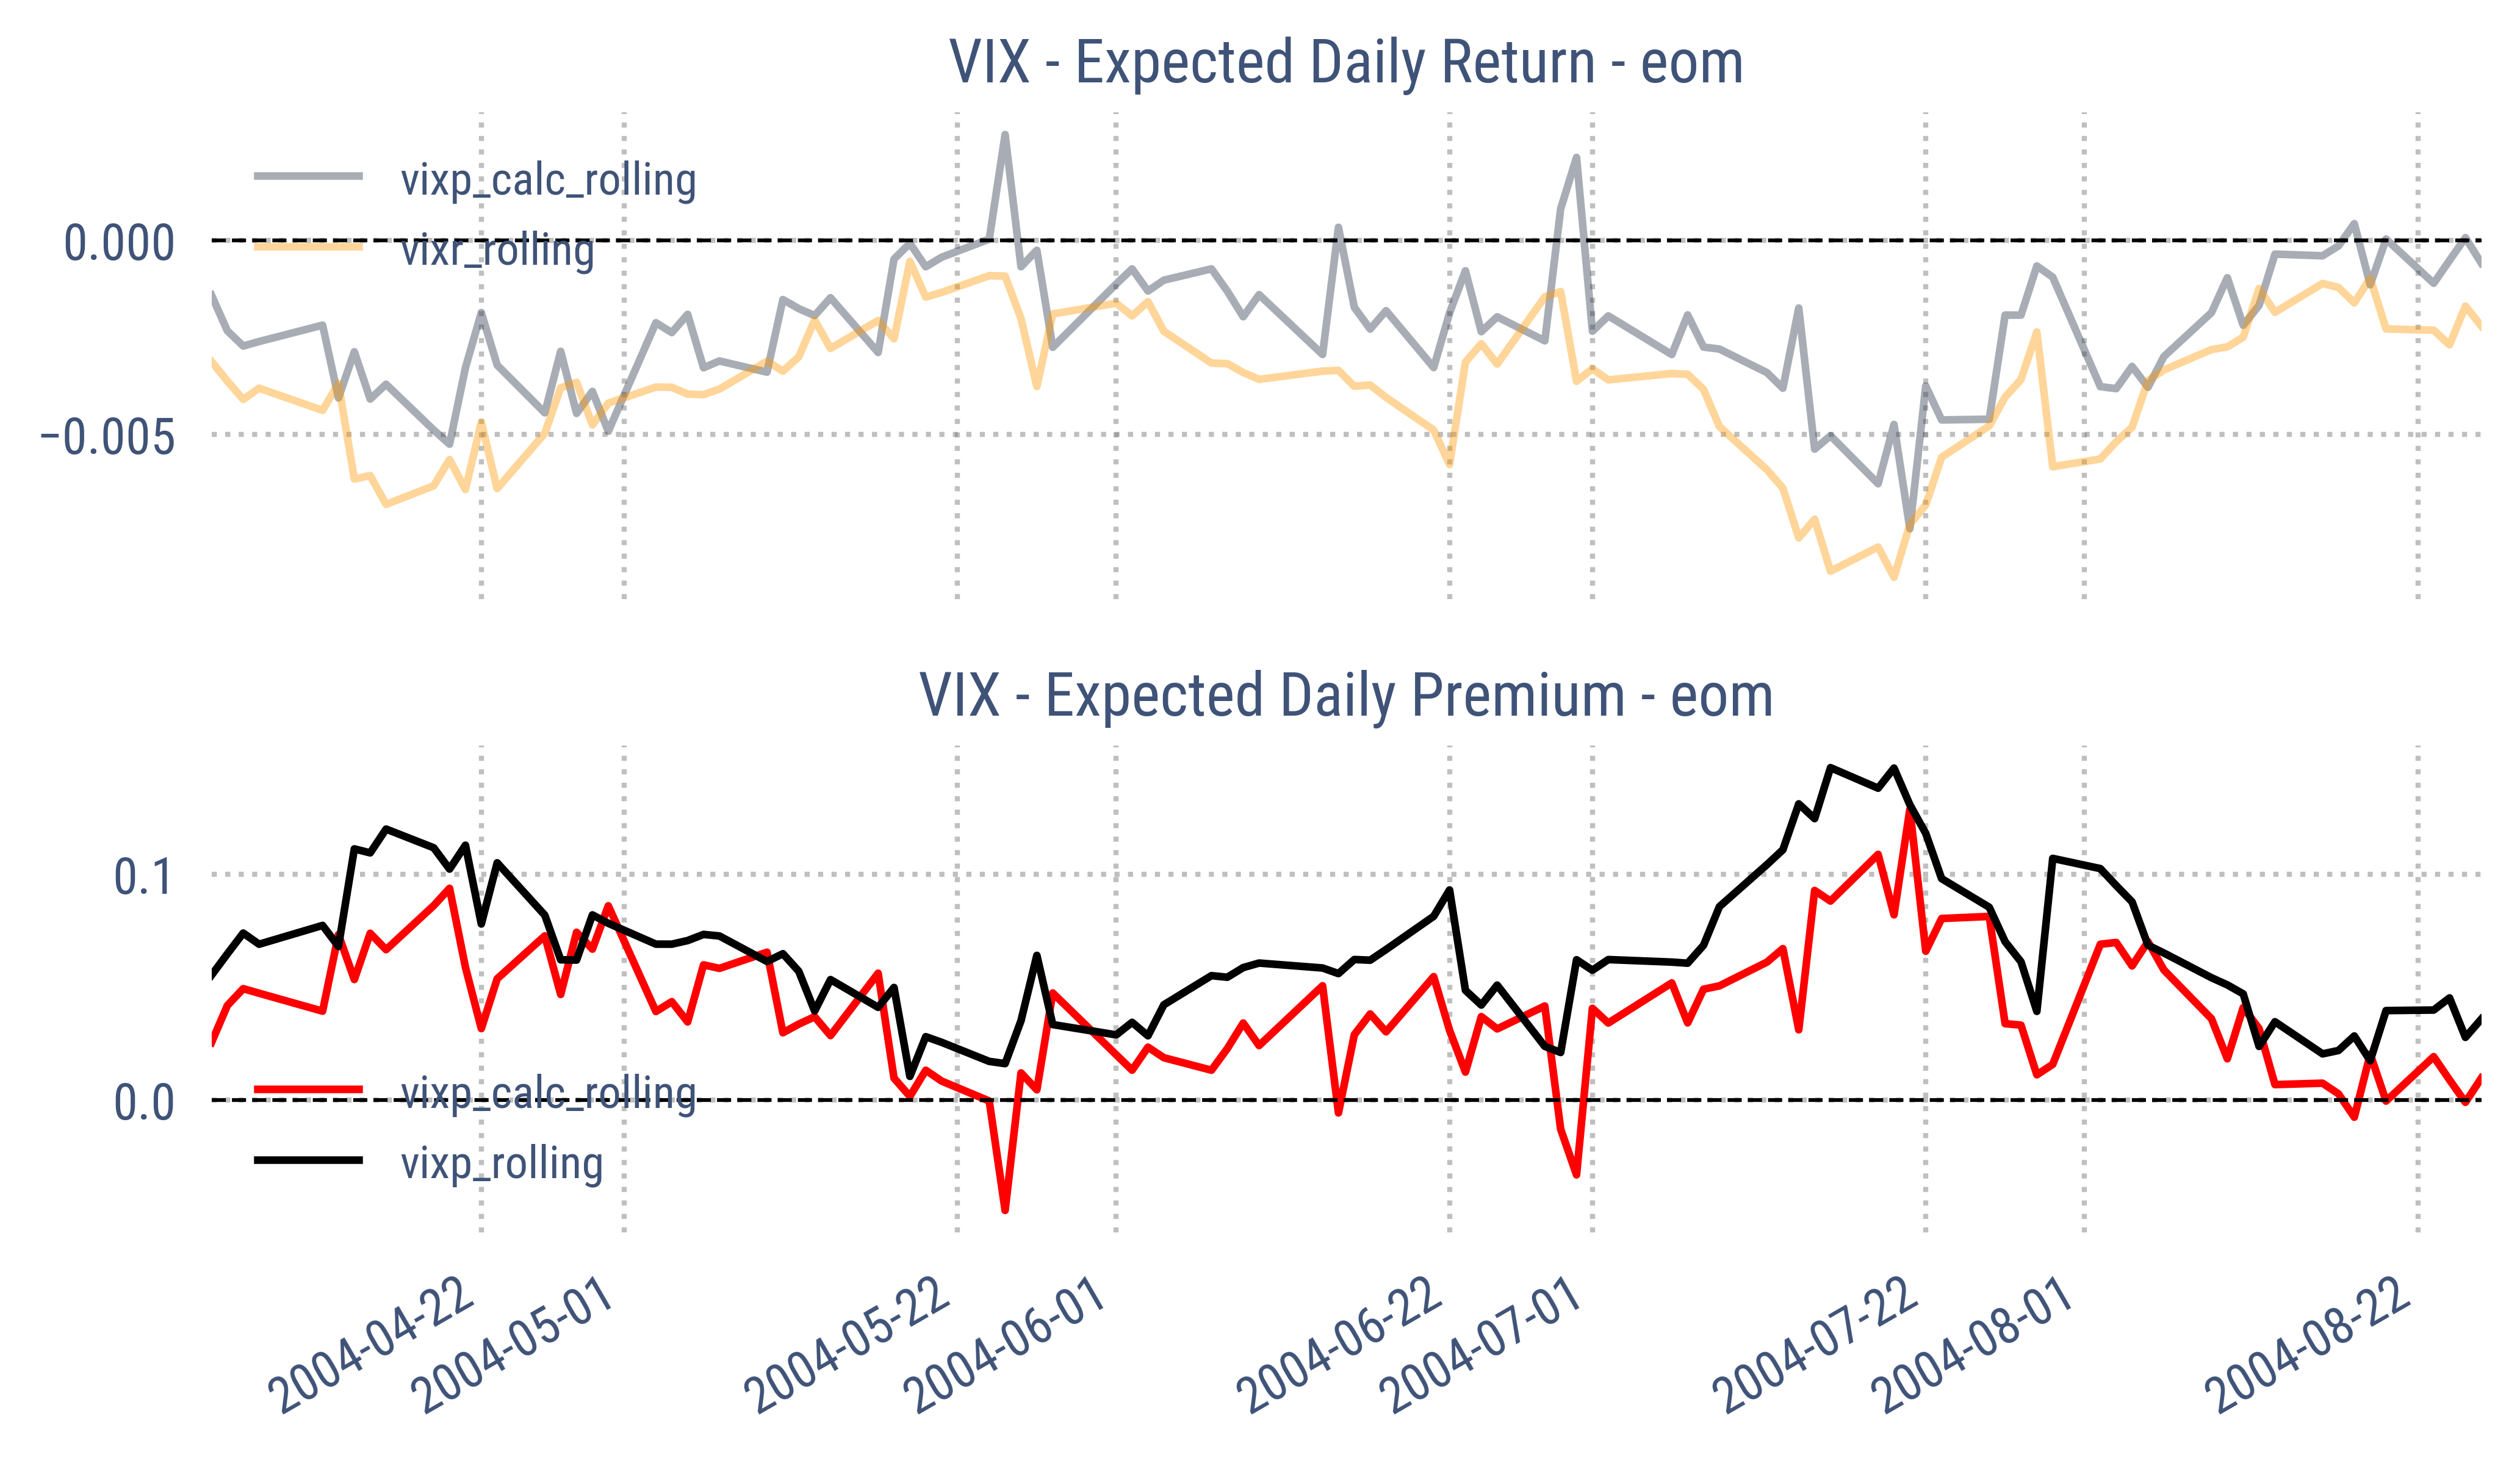

In [61]:
vixr_calc, vixp_calc = [pd.Series(index=test.index, data=item, name='vixp_calc_rolling') for item, name in 
                       zip([vixer_ts, vixp_ts], ['vixr_calc_rolling', 'vixp_calc_rolling'])]

fig = plt.figure(figsize=pc.fig_size,
                 dpi=600, 
                 facecolor='None', 
                 edgecolor='None')
gs = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.3)

ax_vixr = plt.subplot(gs[0, :])
ax_vixp_test = plt.subplot(gs[1, :], sharex=ax_vixr)

_ = vixr_calc.plot(color=pc.color_dark,
                              lw=1.5,
                              ax=ax_vixr, 
                              grid=True,
                              alpha=0.4,
                              title ='VIX - Expected Daily Return - {}'.format(expiry_type))
chart_format([ax_vixr], pc.color_light)
ax2 = vixp_d['vixr_rolling'][test.index].plot(secondary_y=False,
                                        ax=ax_vixr,
                                        color=pc.color_yellow,
                                        lw=1.5,
                                        alpha=0.4)
ax_vixr.axhline(0,
             color='k',
             ls='--',
             lw=0.75,
             alpha=1.0)
legend_1 = ax_vixr.legend(framealpha=0.0)

vixp_calc.plot(color='r', ax=ax_vixp_test, title ='VIX - Expected Daily Premium - {}'.format(expiry_type))
vixp_d['vixp_rolling'][test.index].plot(secondary_y=False, ax=plt.gca(), color='k')
chart_format([plt.gca()], pc.color_light)
legend_2 = ax_vixp_test.legend(framealpha=0.0)

[(text.set_size(pc.font_size), text.set_color(pc.color_light)) for text in legend_1.get_texts() + 
                                                                            legend_2.get_texts()]
chart_format([ax2, ax_vixp_test], pc.color_light)
ax_vixp_test.axhline(0,
             color='k',
             ls='--',
             lw=0.75,
             alpha=1.0)
plt.autoscale(enable=True,
              axis='x',
              tight=True)

# Tables and Correlations
table3 = pd.concat([table1_stats(vixp_d['vixp_rolling'][vixp_calc.index[0]:vixp_calc.index[-1]].dropna(how='any'), 'VIXP', 100),
                    table1_stats(vixp_calc.dropna(how='any'), 'VIXP_calc', 100),
                    table1_stats(vixp_d['vixr_rolling'][vixp_calc.index[0]:vixp_calc.index[-1]].dropna(how='any'), 'VIXR', 100),
                    table1_stats(vixr_calc.dropna(how='any'), 'VIXR_calc', 100)], axis=1)

display(table3.transpose().style.set_caption('Table2. Daily Summary Statistics').format({'mean': '{:,.3f}', 'std': '{:,.3f}', 'min': '{:,.2f}',
                                    'max': '{:,.3f}', '50%': '{:,.3f}'}))
display(pd.concat([vixp_d['vixp_rolling'][vixp_calc.index[0]:vixp_calc.index[-1]], vixp_calc], axis=1).corr())
display(pd.concat([vixp_d['vixr_rolling'], vixr_calc], axis=1).corr())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3596
Model:                     ARMA(2, 2)   Log Likelihood               -5891.369
Method:                       css-mle   S.D. of innovations              1.245
Date:                Thu, 28 Feb 2019   AIC                          11794.737
Time:                        10:57:08   BIC                          11831.863
Sample:                             0   HQIC                         11807.969
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9806      1.538     12.989      0.000      16.966      22.996
ar.L1.y        1.6593      0.064     25.737      0.000       1.533       1.786
ar.L2.y       -0.6621      0.064    -10.397      0.000      -0.787      -0.537
ma.L1.y       -0.7213      0.066    -10.934      0.000      -0.851      -0.592
ma.L2.y       -0.0634      0.021     -2.997      0.003      -0.105      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0086           +0.0000j            1.0086            0.0000
AR.2            1.4976           +0.0000j            1.4976            0.0000
MA.1            1.2492           +0.0000j            1.2492            0.0000
MA.2          -12.6261           +0.0000j           12.6261            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
roll_rows['05-2004'].shift(-1).fillna(np.nan)

In [29]:
vx.rolled_idx.index[:1]

DatetimeIndex(['2004-04-05'], dtype='datetime64[ns]', freq=None)

In [33]:
Dep. Variable:	y	No. Observations:	3596
Model:	ARMA(2, 2)	Log Likelihood	-5891.369
Method:	mle	S.D. of innovations	1.245
Date:	Thu, 28 Feb 2019	AIC	11794.737
Time:	11:00:04	BIC	11831.863
Sample:	0	HQIC	11807.969
coef	std err	z	P>|z|	[0.025	0.975]
const	19.9806	1.538	12.989	0.000	16.966	22.996
ar.L1.y	1.6593	0.064	25.737	0.000	1.533	1.786
ar.L2.y	-0.6621	0.064	-10.397	0.000	-0.787	-0.537
ma.L1.y	-0.7213	0.066	-10.934	0.000	-0.851	-0.592
ma.L2.y	-0.0634	0.021	-2.997	0.003	-0.105	-0.022


1990-01-02    17.240000
1990-01-03    18.190001
1990-01-04    19.219999
1990-01-05    20.110001
1990-01-08    20.260000
1990-01-09    22.200001
1990-01-10    22.440001
1990-01-11    20.049999
1990-01-12    24.639999
1990-01-15    26.340000
1990-01-16    24.180000
1990-01-17    24.160000
1990-01-18    24.340000
1990-01-19    22.500000
1990-01-22    26.700001
1990-01-23    24.719999
1990-01-24    25.389999
1990-01-25    25.629999
1990-01-26    26.280001
1990-01-29    26.440001
1990-01-30    27.250000
1990-01-31    25.360001
1990-02-01    24.870001
1990-02-02    24.320000
1990-02-05    24.540001
1990-02-06    24.690001
1990-02-07    24.290001
1990-02-08    23.770000
1990-02-09    23.690001
1990-02-12    24.379999
                ...    
2004-02-23    16.290001
2004-02-24    15.900000
2004-02-25    14.930000
2004-02-26    14.830000
2004-02-27    14.550000
2004-03-01    14.440000
2004-03-02    14.860000
2004-03-03    14.550000
2004-03-04    14.400000
2004-03-05    14.480000
2004-03-08    15

In [34]:
test

2004-04-05    14.97
Name: vix_index, dtype: float64

In [35]:
train

1990-01-02    17.240000
1990-01-03    18.190001
1990-01-04    19.219999
1990-01-05    20.110001
1990-01-08    20.260000
1990-01-09    22.200001
1990-01-10    22.440001
1990-01-11    20.049999
1990-01-12    24.639999
1990-01-15    26.340000
1990-01-16    24.180000
1990-01-17    24.160000
1990-01-18    24.340000
1990-01-19    22.500000
1990-01-22    26.700001
1990-01-23    24.719999
1990-01-24    25.389999
1990-01-25    25.629999
1990-01-26    26.280001
1990-01-29    26.440001
1990-01-30    27.250000
1990-01-31    25.360001
1990-02-01    24.870001
1990-02-02    24.320000
1990-02-05    24.540001
1990-02-06    24.690001
1990-02-07    24.290001
1990-02-08    23.770000
1990-02-09    23.690001
1990-02-12    24.379999
                ...    
2004-02-23    16.290001
2004-02-24    15.900000
2004-02-25    14.930000
2004-02-26    14.830000
2004-02-27    14.550000
2004-03-01    14.440000
2004-03-02    14.860000
2004-03-03    14.550000
2004-03-04    14.400000
2004-03-05    14.480000
2004-03-08    15

In [37]:
vix['04-2004']

2004-04-01    16.650000
2004-04-02    15.640000
2004-04-05    14.970000
2004-04-06    15.320000
2004-04-07    15.760000
2004-04-08    16.260000
2004-04-12    15.280000
2004-04-13    17.260000
2004-04-14    15.620000
2004-04-15    15.740000
2004-04-16    14.940000
2004-04-19    15.420000
2004-04-20    16.670000
2004-04-21    15.600000
2004-04-22    14.610000
2004-04-23    14.010000
2004-04-26    14.770000
2004-04-27    15.070000
2004-04-28    16.290001
2004-04-29    16.600000
2004-04-30    17.190001
Name: vix_index, dtype: float64